In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from torchinfo import summary
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import deepwave as dw

In [2]:
device = 'cuda'
torch.set_default_device(device)
torch.set_default_dtype(torch.float32)

In [3]:
nx = 128
ny = 32
dx = 5.

vp_init, vs_init, rho_init = 1500, 1000, 2200

vp_background = torch.ones(ny, nx, device=device) * vp_init
vs_background = torch.ones(ny, nx, device=device) * vs_init
rho_background = torch.ones(ny, nx, device=device) * rho_init

In [4]:
vp_true = vp_background.clone()
vp_true[10:20, 30:40] = 1600
vs_true = vs_background.clone()
vs_true[10:20, 45:55] = 1100
rho_true = rho_background.clone()
rho_true[10:20, 60:70] = 2300

/home/ptribel/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/ptribel/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


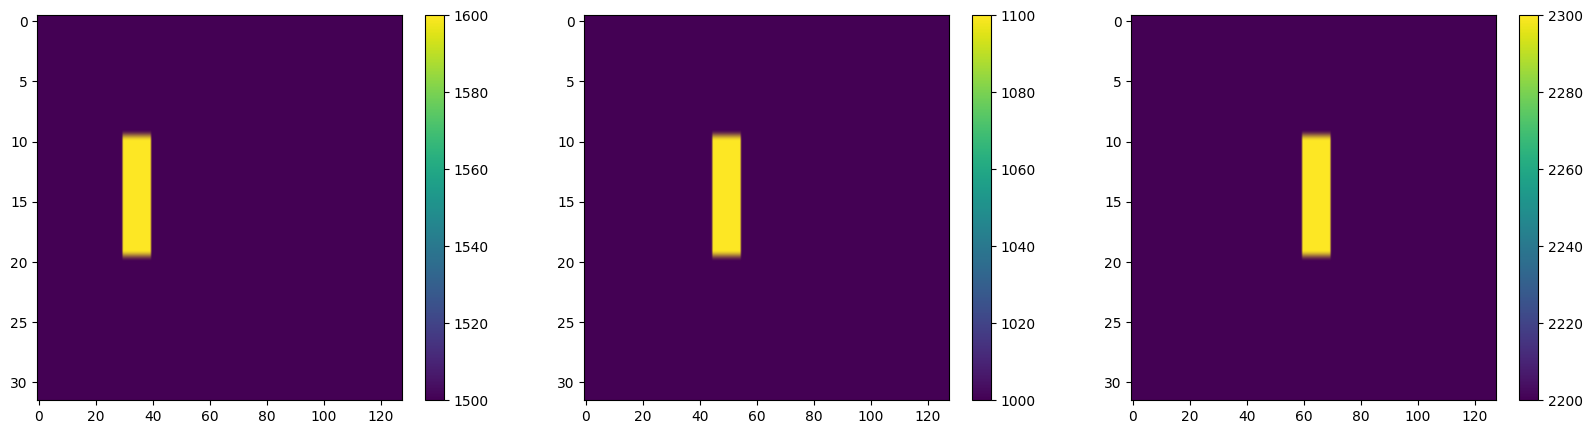

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
plt.colorbar(ax[0].imshow(vp_true.cpu(), aspect='auto'))
plt.colorbar(ax[1].imshow(vs_true.cpu(), aspect='auto'))
plt.colorbar(ax[2].imshow(rho_true.cpu(), aspect='auto'))
plt.show()

In [6]:
n_shots = 8
n_sources_per_shot = 1
d_source = 12 
first_source = 4
source_depth = 2

n_receivers_per_shot = nx-1
d_receiver = 1
first_receiver = 0
receiver_depth = 2

In [7]:
freq = 15
nt = 800
dt = 0.001
peak_time = 1.5 / freq

In [8]:
source_locations = torch.zeros(n_shots, n_sources_per_shot, 2, dtype=torch.float32, device=device)
source_locations[..., 0] = source_depth
source_locations[:, 0, 1] = (torch.arange(n_shots) * d_source + first_source)

In [9]:
receiver_locations = torch.zeros(n_shots, n_receivers_per_shot, 2, dtype=torch.float32, device=device)
receiver_locations[..., 0] = receiver_depth
receiver_locations[:, :, 1] = (torch.arange(n_receivers_per_shot) * d_receiver + first_receiver).repeat(n_shots, 1)

In [10]:
source_amplitudes = (dw.wavelets.ricker(freq, nt, dt, peak_time)).repeat(n_shots, n_sources_per_shot, 1).to(device)

In [11]:
observed_data = torch.stack(dw.elastic(*dw.common.vpvsrho_to_lambmubuoyancy(vp_true, vs_true, rho_true), dx, dt,
                        source_amplitudes_y=source_amplitudes,
                        source_locations_y=source_locations,
                        receiver_locations_x=receiver_locations,
                        receiver_locations_y=receiver_locations,
                        pml_width=[0, 20, 20, 20]
)[-2:])

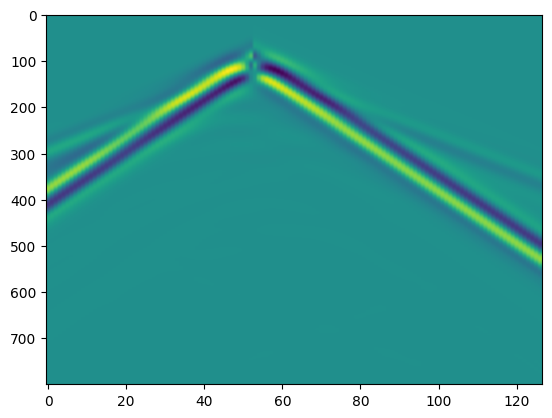

In [12]:
plt.imshow(observed_data[1, n_shots//2].cpu().T, aspect='auto')
plt.show()

  0%|          | 0/30 [00:00<?, ?it/s]

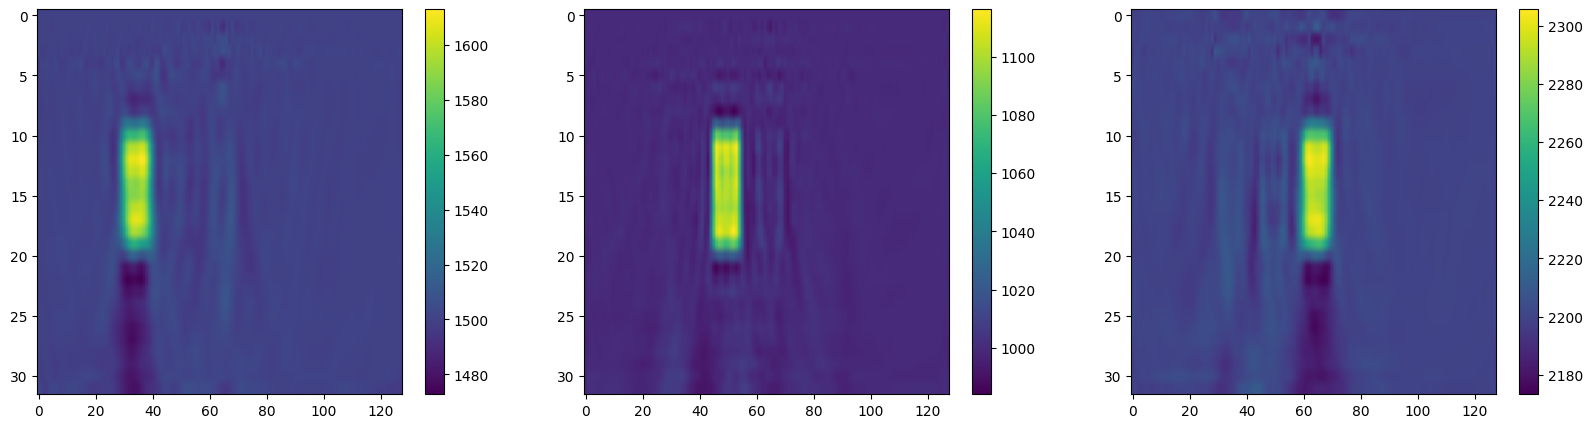

In [13]:
vp_lbfgs = vp_background.clone().requires_grad_()
vs_lbfgs = vs_background.clone().requires_grad_()
rho_lbfgs = rho_background.clone().requires_grad_()

optimiser = optim.LBFGS([vp_lbfgs, vs_lbfgs, rho_lbfgs])
loss_fn = nn.MSELoss()

n_epochs = 30

losses_lbfgs = []

for epoch in (pbar:=tqdm(range(n_epochs))):
    def closure():
        optimiser.zero_grad()
        out = torch.stack(dw.elastic(
            *dw.common.vpvsrho_to_lambmubuoyancy(vp_lbfgs, vs_lbfgs, rho_lbfgs),
            dx, dt,
            source_amplitudes_y=source_amplitudes,
            source_locations_y=source_locations,
            receiver_locations_x=receiver_locations,
            receiver_locations_y=receiver_locations,
            pml_width=[0, 20, 20, 20]
        )[-2:])
        loss = 1e20*loss_fn(out, observed_data)
        loss.backward()
        losses_lbfgs.append(loss.item())
        pbar.set_description(f"Epoch {epoch} - Loss: {loss.item():5e}")
        return loss
    optimiser.step(closure)

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
plt.colorbar(ax[0].imshow(vp_lbfgs.detach().cpu(), aspect='auto'))
plt.colorbar(ax[1].imshow(vs_lbfgs.detach().cpu(), aspect='auto'))
plt.colorbar(ax[2].imshow(rho_lbfgs.detach().cpu(), aspect='auto'))
plt.show()

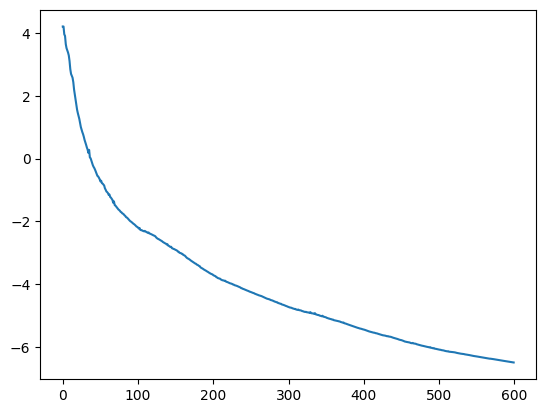

In [14]:
plt.plot(np.log(losses_lbfgs))

summary(model, input_data=observed_data[0:1])

In [42]:
vp_lbfgs = vp_background.clone().requires_grad_()
vs_lbfgs = vs_background.clone().requires_grad_()
rho_lbfgs = rho_background.clone().requires_grad_()

class VelocityNet(nn.Module):
    def __init__(self, input_shape, output_shape):
        super().__init__()
        n_shots, nx, nt = input_shape
        ny, nx_out = output_shape
        
        self.conv1 = nn.Conv2d(in_channels=nx-1, out_channels=nx, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=nt, out_channels=ny, kernel_size=3, padding=1)
        self.fc3 = nn.Linear(n_shots, 1)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        x = x.view(n_shots, nx-1, 1, nt)
        x = self.tanh(self.conv1(x)).permute(0, 3, 1, 2)
        x = self.tanh(self.conv2(x)).squeeze().permute(1, 2, 0)
        x = self.tanh(self.fc3(x).squeeze())
        return x
        
class VelocityModel(nn.Module):
    def __init__(self, input_shape, output_shape):
        super().__init__()
        self.vp_net = VelocityNet(input_shape, output_shape)
        self.vp_alpha = nn.Parameter(torch.tensor([1e-5]))
        self.vs_net = VelocityNet(input_shape, output_shape)
        self.vs_alpha = nn.Parameter(torch.tensor([1e-5]))
        self.rho_net = VelocityNet(input_shape, output_shape)
        self.rho_alpha = nn.Parameter(torch.tensor([1e-5]))
        self.activation = nn.Sigmoid()
        
    def forward(self, x):
        vp = self.activation(self.vp_alpha) * self.vp_net(x) + (1-self.activation(self.vp_alpha)) * vp_lbfgs
        vs = self.activation(self.vs_alpha) * self.vs_net(x) + (1-self.activation(self.vs_alpha)) * vs_lbfgs
        rho = self.activation(self.rho_alpha) * self.rho_net(x) + (1-self.activation(self.rho_alpha)) * rho_lbfgs
        return vp, vs, rho

torch.manual_seed(0)
model = VelocityModel(input_shape=(n_shots, nx, nt), output_shape=(ny, nx))


loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
optimizer_lbfgs = optim.LBFGS([vp_lbfgs, vs_lbfgs, rho_lbfgs])
n_epochs = 30

for epoch in (pbar:=tqdm(range(n_epochs))):
    for _ in range(10):
        def closure():
            optimizer.zero_grad()
            out = torch.stack(dw.elastic(
                *dw.common.vpvsrho_to_lambmubuoyancy(*model(observed_data[0:1])),
                dx, dt,
                source_amplitudes_y=source_amplitudes,
                source_locations_y=source_locations,
                receiver_locations_x=receiver_locations,
                receiver_locations_y=receiver_locations,
                pml_width=[0, 20, 20, 20]
            )[-2:])
            loss = 1e20*loss_fn(out, observed_data)
            loss.backward()
            pbar.set_description(f"Epoch {epoch} - Loss: {loss.item():5e}")
            return loss
        optimizer.step(closure)
    def closure_lbfgs():
        optimizer_lbfgs.zero_grad()
        out = torch.stack(dw.elastic(
            *dw.common.vpvsrho_to_lambmubuoyancy(vp_lbfgs, vs_lbfgs, rho_lbfgs),
            dx, dt,
            source_amplitudes_y=source_amplitudes,
            source_locations_y=source_locations,
            receiver_locations_x=receiver_locations,
            receiver_locations_y=receiver_locations,
            pml_width=[0, 20, 20, 20]
        )[-2:])
        loss = 1e20*loss_fn(out, observed_data)
        loss.backward()
        #losses_lbfgs.append(loss.item())
        pbar.set_description(f"Epoch {epoch} - Loss: {loss.item():5e}")
        return loss
    optimizer_lbfgs.step(closure_lbfgs)

  0%|          | 0/30 [00:00<?, ?it/s]

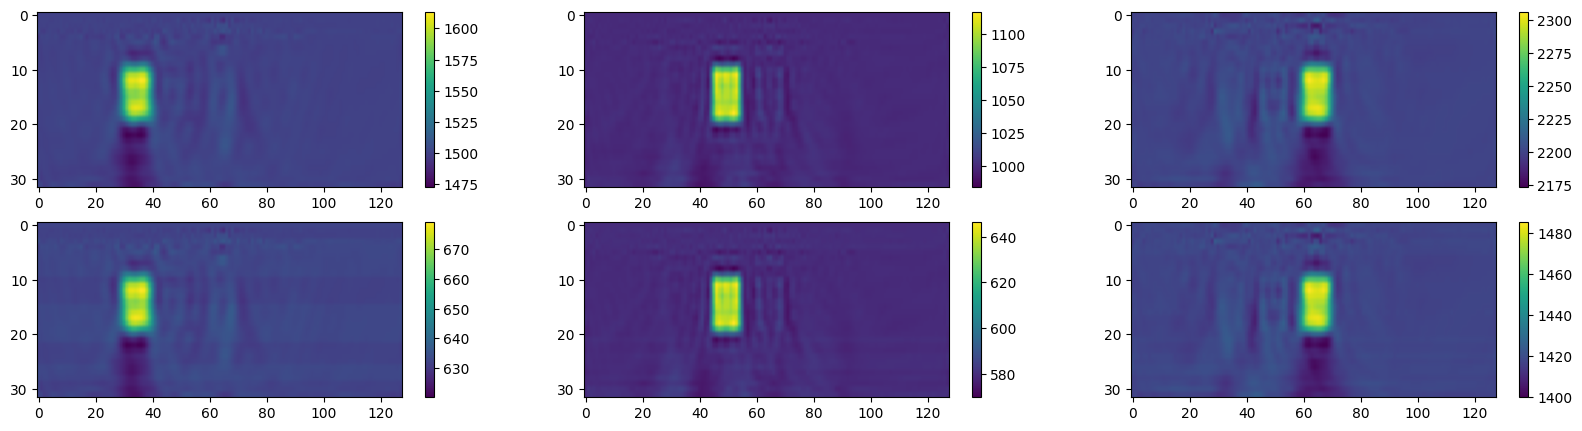

In [44]:
vp_hat, vs_hat, rho_hat = model(observed_data[0:1])
fig, ax = plt.subplots(2, 3, figsize=(20, 5))
plt.colorbar(ax[0, 0].imshow(vp_lbfgs.detach().cpu(), aspect='auto'))
plt.colorbar(ax[0, 1].imshow(vs_lbfgs.detach().cpu(), aspect='auto'))
plt.colorbar(ax[0, 2].imshow(rho_lbfgs.detach().cpu(), aspect='auto'))
plt.colorbar(ax[1, 0].imshow(vp_hat.detach().cpu(), aspect='auto'))
plt.colorbar(ax[1, 1].imshow(vs_hat.detach().cpu(), aspect='auto'))
plt.colorbar(ax[1, 2].imshow(rho_hat.detach().cpu(), aspect='auto'))
plt.show()

In [ ]:
print(model.vp_alpha, model.vs_alpha, model.rho_alpha)